<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 3

## Data Preperation

### Research Assignment Reporting Functions

In [1]:
# Accuracy and loss Line plots visual
def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

In [2]:
# Shows Accuracy & Root Mean Square Error scores
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [3]:
# Confusion Matrix visual
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

### Import packages 

In [4]:
import datetime
from datetime import datetime as dt 
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import string
import nltk
from nltk.corpus import stopwords
from collections import Counter
import re

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

In [5]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Stopword Function

In [6]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

### Analyze AG_NEWS_SUBSET Data <br>

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.<br> 

For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html<br> 


The AG's news topic classification dataset is constructed by choosing 4 largest classes (**World**, **Sports**, **Business**, and **Sci/Tech**) from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.<br>

Homepage: https://arxiv.org/abs/1509.01626<br>

Source code: tfds.text.AGNewsSubset

Versions:

1.0.0 (default): No release notes.
Download size: 11.24 MiB

Dataset size: 35.79 MiB

<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div>

In [7]:
#!conda install -c anaconda tensorflow-datasets --y
#!pip install -c anaconda tensorflow-datasets --y

### Load AG_NEWS_SUBSET News Articles Dataset

In [8]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test'],
                          batch_size = 32, as_supervised=True)
train_ds, val_ds, test_ds = dataset

2022-10-29 19:04:05.895223: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
W1029 19:04:05.895579 140115602253696 download_and_prepare.py:43] ***`tfds build` should be used instead of `download_and_prepare`.***
INFO[build.py]: Loading dataset ag_news_subset from imports: tensorflow_datasets.text.ag_news_subset
2022-10-29 19:04:06.058382: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "NOT_FOUND: Error executing an HTTP request: HTTP response code 404".
INFO[dataset_info.py]: Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: ag_news_subset/1.0.0
INFO[dataset_info.py]: Load dataset info from /tmp/tmpw8mwm3gutfds
INFO[dataset_info.py]: Field info.spli

### Deep learning for text

#### Natural-language processing: The bird's eye view

Handcrafted rules held out as the dominant approach well into the 1990s. But starting in the late 1980s, faster computers and greater data availability started making a better alternative viable. 

We started seeing machine learning approaches to natural language processing. The earliest ones were based on `decision trees`—the intent was literally to automate the development of the kind of if/then/else rules of previous systems

Then statistical approaches started gaining speed, starting with `logistic regression`. Over time, learned parametric models fully took over, and linguistics came to be seen as more of a hindrance than a useful tool. 

In early 2015, Keras made available the first open source, easy-to-use implementation of `LSTM`, just at the start of a massive wave of renewed interest in recurrent neural networks—until then, there had only been “research code” that couldn’t be readily reused. 

Then from 2015 to 2017, recurrent neural networks dominated the booming NLP scene. `Bidirectional LSTM` models, in particular, set the state of the art on many important tasks, from summarization to question-answering to machine translation.

Finally, around 2017–2018, a new architecture rose to replace RNNs: the `Transformer`. Transformers unlocked considerable progress across the field in a short period of time, and today most NLP systems are based on them.

### Common Natural Language Processing Tasks

The applications of natural language algorithms are commonly called tasks. Here are some popular tasks:

1. **Sentiment Analysis**: Given opinionated text like a movie review, determine whether the overall sense is positive or negative.
2. **Translation**: Turn text into another language.
Answer Questions: Answer questions about the text, like who is the hero, or what actions occurred.
3. **Summarize or Paraphrase**: Provide a short overview of the text, emphasizing the main points.
4. **Generate New Text**: Given some starting text, write more text that seems to follow from it.
5. **Logical Flow**: If a sentence first asserts a premise and the following sentence asserts a conclusion based on that premise, determine whether the conclusion logically follows from the premise.

### Preparing text data

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/11-01.png?raw=1">


#### Text standardization

Text standardization is a basic form of feature engineering that aims to erase encoding differences that you don’t want your model to have to deal with. It’s not exclusive to machine learning, either—you’d have to do the same thing if you were building a search engine.

One of the simplest and most widespread standardization schemes is “convert to lowercase and remove punctuation characters.” 

With these standardization techniques, your model will require less training data and will generalize better—it won’t need abundant examples of both “Sunset” and “sunset” to learn that they mean the same thing...

#### Text splitting (tokenization)

Once your text is standardized, you need to break it up into units to be vectorized (tokens), a step called tokenization. You could do this in three different ways:

* `Word-level tokenization`—Where tokens are space-separated (or punctuation-separated) substrings. A variant of this is to further split words into subwords when applicable—for instance, treating “staring” as “star+ing” or “called” as “call+ed.”
* `N-gram tokenization`—Where tokens are groups of N consecutive words. For instance, “the cat” or “he was” would be 2-gram tokens (also called bigrams).
* `Character-level tokenization`—Where each character is its own token. In practice, this scheme is rarely used, and you only really see it in specialized contexts, like text generation or speech recognition.


Here’s a simple example. Consider the sentence “the cat sat on the mat.” It may be decomposed into the following set of 2-grams:

`{"the", "the cat", "cat", "cat sat", "sat",
 "sat on", "on", "on the", "the mat", "mat"}`

It may also be decomposed into the following set of 3-grams:

`{"the", "the cat", "cat", "cat sat", "the cat sat",
 "sat", "sat on", "on", "cat sat on", "on the",
 "sat on the", "the mat", "mat", "on the mat"}`

`One-dimensional convnets`, `recurrent neural networks`, and `Transformers` are capable of learning representations for groups of words and characters without being explicitly told about the existence of such groups, by looking at continuous word or character sequences.

#### Vocabulary indexing

1. Build an index of all terms found in the training data (the “vocabulary”), and assign a unique integer to each entry in the vocabulary.
```python
vocabulary = {} 
for text in dataset:
    text = standardize(text)
    tokens = tokenize(text)
    for token in tokens:
        if token not in vocabulary:
            vocabulary[token] = len(vocabulary)
```

2. You can then convert that integer into a vector encoding that can be processed by a neural network, like a one-hot vector:
```python
def one_hot_encode_token(token):
    vector = np.zeros((len(vocabulary),))
    token_index = vocabulary[token]
    vector[token_index] = 1 
    return vector
```

#### Using the TextVectorization layer

```python
import string
  
class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text 
                       if char not in string.punctuation)
  
    def tokenize(self, text):
        text = self.standardize(text)
        return text.split()
  
    def make_vocabulary(self, dataset):
        self.vocabulary = {"": 0, "[UNK]": 1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict(
            (v, k) for k, v in self.vocabulary.items())
  
    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token, 1) for token in tokens]
  
    def decode(self, int_sequence):
        return " ".join(
            self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)
  
vectorizer = Vectorizer()
# Haiku by poet Hokushi
dataset = [           
    "I write, erase, rewrite",   
    "Erase again, and then",     
    "A poppy blooms.",           
]
vectorizer.make_vocabulary(dataset)
```

```python
>>> test_sentence = "I write, rewrite, and still rewrite again" 
>>> encoded_sentence = vectorizer.encode(test_sentence)
>>> print(encoded_sentence)
[2, 3, 5, 7, 1, 5, 6]
>>> decoded_sentence = vectorizer.decode(encoded_sentence)
>>> print(decoded_sentence)
"i write rewrite and [UNK] rewrite again" 
```

However, using something like this wouldn’t be very performant. In practice, you’ll work with the Keras `TextVectorization` layer, which is fast and efficient and can be dropped directly into a `tf.data` pipeline or a Keras model.

```python
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(
    output_mode="int",    # Configures the layer to return sequences of words encoded as integer indices. 
)


By default, the `TextVectorization` layer will use the setting “convert to lowercase and remove punctuation” for text standardization, and “split on whitespace” for tokenization. 

```python
import re 
import string 
import tensorflow as tf
  
def custom_standardization_fn(string_tensor):
    lowercase_string = tf.strings.lower(string_tensor)              ❶
    return tf.strings.regex_replace(                                ❷
        lowercase_string, f"[{re.escape(string.punctuation)}]", "")
  
def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor)                          ❸
 
text_vectorization = TextVectorization(
    output_mode="int",
    standardize=custom_standardization_fn,
    split=custom_split_fn,
)
```

❶ Convert strings to lowercase.

❷ Replace punctuation characters with the empty string.

❸ Split strings on whitespace.

To index the vocabulary of a text corpus, just call the `adapt()` method of the layer with a `Dataset` object that yields strings, or just with a list of Python strings:
```python
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]
text_vectorization.adapt(dataset)
```

Note that you can retrieve the computed vocabulary via `get_vocabulary()`
```python
>>> text_vectorization.get_vocabulary()
["", "[UNK]", "erase", "write", ...]
```

This method can be useful if you need to convert text encoded as integer sequences back into words. The first two entries in the vocabulary are the `mask` token (index 0) and the `OOV` token (index 1). 

Entries in the vocabulary list are sorted by frequency, so with a real-world dataset, very common words like “the” or “a” would come first.

#### Two ways we could use our `TextVectorization` layer

#####  The first option is to put it in the `tf.data pipeline`, like this:

There are two ways we could use our TextVectorization layer. The first option is to put it in the `tf.data pipeline`, like this:
```python
int_sequence_dataset = string_dataset.map(   ❶
    text_vectorization,
    num_parallel_calls=4)                    ❷
```

❶ string_dataset would be a dataset that yields string tensors.

❷ The num_parallel_calls argument is used to parallelize the map() call across multiple CPU cores.

##### The second option is to make it part of the `model` (after all, it’s a Keras layer), like this:

The second option is to make it part of the model (after all, it’s a Keras layer), like this:
```python
text_input = keras.Input(shape=(), dtype="string")             ❶
vectorized_text = text_vectorization(text_input)               ❷
embedded_input = keras.layers.Embedding(...)(vectorized_text)  ❸
output = ...                                                   ❸
model = keras.Model(text_input, output) 
```
❶ Create a symbolic input that expects strings.

❷ Apply the text vectorization layer to it.

❸ You can keep chaining new layers on top—just your regular Functional API model.

***There’s an important difference between the two**: if the vectorization step is part of the model, it will happen synchronously with the rest of the model. This means that at each training step, the rest of the model (placed on the GPU) will have to wait for the output of the TextVectorization layer (placed on the CPU) to be ready in order to get to work. 

Meanwhile, putting the layer in the `tf.data` pipeline enables you to do asynchronous preprocessing of your data on CPU: while the GPU runs the model on one batch of vectorized data, the CPU stays busy by vectorizing the next batch of raw strings.

So if you’re training the model on GPU or TPU, you’ll probably want to go with the first option to get the best performance.

Now, if you were to export our model to a production environment, you would want to ship a model that accepts raw strings as input—otherwise you would have to reimplement text standardization and tokenization in your production environment (maybe in JavaScript?), and you would face the risk of introducing small preprocessing discrepancies that would hurt the model’s accuracy. Thankfully, the TextVectorization layer enables you to include text preprocessing right into your model, making it easier to deploy.

#### Exporting a model that processes raw strings

```python
inputs = keras.Input(shape=(1,), dtype="string")   ❶
processed_inputs = text_vectorization(inputs)      ❷
outputs = model(processed_inputs)                  ❸
inference_model = keras.Model(inputs, outputs)     ❹
```

❶ One input sample would be one string.

❷ Apply text preprocessing.

❸ Apply the previously trained model.

❹ Instantiate the end-to-end model.

The resulting model can process batches of `raw strings`:
```python
import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
    ["That was an excellent movie, I loved it."],
])
predictions = inference_model(raw_text_data) 
print(f"{float(predictions[0] * 100):.2f} percent positive")
```

#### Verify TensorFlow Version and Keras Version

In [9]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.9.2


In [10]:
print("Keras version: ", keras.__version__)

Keras version:  2.9.0


#### Mount Google Drive to Colab Environment

In [11]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#### Visualization Utility Functions

In [12]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

#### Vectorization Class

In [13]:
class Vectorizer:
    def standardize(self, text):
        text = text.lower()
        return "".join(char for char in text if char not in string.punctuation)

    def tokenize(self, text):
        text = self.standardize(text)
        return text.split()

    def make_vocabulary(self, dataset):
        self.vocabulary = {"": 0, "[UNK]": 1}
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict(
            (v, k) for k, v in self.vocabulary.items())

    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token, 1) for token in tokens]

    def decode(self, int_sequence):
        return " ".join(
            self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)


### Display The Number of Batches

In [14]:
len(train_ds), len(val_ds), len(test_ds)

(3563, 188, 238)

### Displaying The Shapes and Dtypes of the First Batch

In [15]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print()
    print("inputs.dtype:", inputs.dtype)
    print()
    print("targets.shape:", targets.shape)
    print()
    print("targets.dtype:", targets.dtype)
    print()
    print("inputs[0]:", inputs[0])
    print()
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)

inputs.dtype: <dtype: 'string'>

targets.shape: (32,)

targets.dtype: <dtype: 'int64'>

inputs[0]: tf.Tensor(b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.', shape=(), dtype=string)

targets[0]: tf.Tensor(3, shape=(), dtype=int64)


### Stop words and Text vectorization

<div class="alert alert-block alert-success">
    <b>tf.keras.layers.TextVectorization</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
    </div>

In [16]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

In [17]:
nltk.download('stopwords')
STOPWORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
text_only_train_ds = train_ds.map(lambda x, y: x)

In [19]:
# Text Vectorizer

max_length = 150
max_tokens = 1000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
   # output_sequence_length=max_length,
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [20]:
# %%time
# max_length = 150
# max_tokens = 1000
# encoder_1000 = layers.TextVectorization(
#     max_tokens=max_tokens,
#     output_mode="int",
#     output_sequence_length=max_length,
#     standardize=custom_stopwords # removing stop words
# )
# encoder_100.adapt(text_only_train_ds)

# int_train_ds = train_ds.map(
#     lambda x, y: (text_vectorization(x), y),
#     num_parallel_calls=4)
# int_val_ds = val_ds.map(
#     lambda x, y: (text_vectorization(x), y),
#     num_parallel_calls=4)
# int_test_ds = test_ds.map(
#     lambda x, y: (text_vectorization(x), y),
#     num_parallel_calls=4)
# vocab_1000 = np.array(encoder_1000.get_vocabulary());

In [21]:
# %%time
# encoder_1000 = TextVectorization(
#     max_tokens=1000,
#     output_mode="multi_hot")
#    # standardize=custom_stopwords) # removing stop words

In [22]:
# text_only_train_ds = train_ds.map(lambda x, y: x)

In [23]:
# for text in text_only_train_ds:
#     print(f"Get first batch of {text.shape[0]} news articles.\n")
#     print(f"Here is the first news article:\n\n{text[0]}.")
#     break

In [24]:
# %%time
# encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
#     max_tokens=1000,
#     output_sequence_length=150
#     standardize=custom_stopwords)
# encoder.adapt(train_ds.map(lambda text, label: text))

# Experiment B - RNN

## RNN_Model1  

Bidirectional, No Regularization, Default output sequnece layer

### Making the Model

In [231]:
# Define the model

RNN_model1 = tf.keras.Sequential([
                           #  text_vectorization
                              tf.keras.layers.Embedding(input_dim=len(text_vectorization.get_vocabulary())
                              ,output_dim=32
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32)) # Bidirectional
                              ,tf.keras.layers.Dense(32, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax') # 4 classes: World, Sports, Business, Sci.Tech
                          #    ,kernel_regularizer=tf.keras.regularizers.L2(0.001) # Without Regularization
])

In [232]:
# compile the model

RNN_model1.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

In [233]:
# Fit the model

start_time = dt.now()
history = RNN_model1.fit(int_train_ds
                    ,epochs=200
                    ,validation_data=int_val_ds
                    ,validation_steps=10
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)]
                    )
end_time = dt.now()
print(f'RNN_model4 fit time: {end_time-start_time}')

Epoch 1/200
3563/3563 [==============================] - 92s 25ms/step - loss: 0.4937 - accuracy: 0.8184 - val_loss: 0.4207 - val_accuracy: 0.8469
Epoch 2/200
3563/3563 [==============================] - 89s 25ms/step - loss: 0.4052 - accuracy: 0.8539 - val_loss: 0.4119 - val_accuracy: 0.8469
RNN_model4 fit time: 0:03:53.717707


In [234]:
RNN_model1.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_23 (Embedding)    (None, None, 32)          32000     
                                                                 
 bidirectional_9 (Bidirectio  (None, 64)               4160      
 nal)                                                            
                                                                 
 dense_39 (Dense)            (None, 32)                2080      
                                                                 
 dense_40 (Dense)            (None, 4)                 132       
                                                                 
Total params: 38,372
Trainable params: 38,372
Non-trainable params: 0
_________________________________________________________________


In [235]:
RNN_model1.evaluate(int_test_ds)

238/238 [==============================] - 2s 7ms/step - loss: 0.4209 - accuracy: 0.8505


[0.42092207074165344, 0.8505263328552246]

In [236]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [237]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.494,0.818,0.421,0.847
1,0.405,0.854,0.412,0.847


### Plot Training Metrics (Loss and Accuracy)

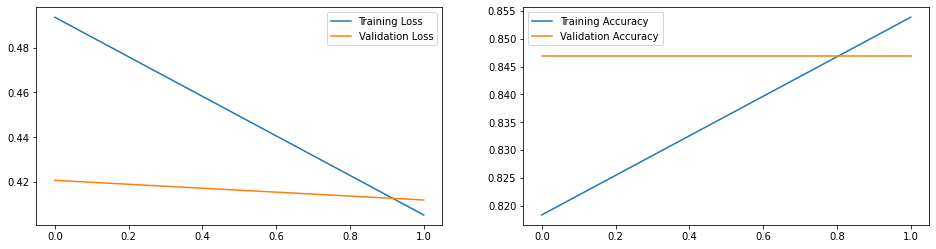

In [238]:
plot_history(history)

### Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [239]:
pred1= RNN_model1.predict(int_test_ds)
pred1=np.argmax(pred1, axis=1)

238/238 [==============================] - 2s 7ms/step


In [240]:
# print_validation_report(int_val_ds, pred1)

In [241]:
# plot_confusion_matrix(int_val_ds,pred1)

## RNN_Model2  

Unidirectional, No Regularization, Default output sequnece layer

### Making the Model

In [242]:
# Define the model

RNN_model2 = tf.keras.Sequential([
                           #  text_vectorization
                              tf.keras.layers.Embedding(input_dim=len(text_vectorization.get_vocabulary())
                              ,output_dim=32
                              ,mask_zero=True)
                              ,tf.keras.layers.SimpleRNN(32) # Unidirectional
                              ,tf.keras.layers.Dense(32, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax') # 4 classes: World, Sports, Business, Sci.Tech
                          #    ,kernel_regularizer=tf.keras.regularizers.L2(0.001) # Without Regularization
])

In [243]:
# compile the model

RNN_model2.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

In [244]:
# Fit the model

start_time = dt.now()
history = RNN_model2.fit(int_train_ds
                    ,epochs=200
                    ,validation_data=int_val_ds
                    ,validation_steps=10
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)]
                    )
end_time = dt.now()
print(f'RNN_model2 fit time: {end_time-start_time}')

Epoch 1/200
3563/3563 [==============================] - 59s 16ms/step - loss: 0.5648 - accuracy: 0.7809 - val_loss: 0.4769 - val_accuracy: 0.8375
Epoch 2/200
3563/3563 [==============================] - 56s 16ms/step - loss: 0.4390 - accuracy: 0.8451 - val_loss: 0.4479 - val_accuracy: 0.8406
Epoch 3/200
3563/3563 [==============================] - 57s 16ms/step - loss: 0.4117 - accuracy: 0.8531 - val_loss: 0.4390 - val_accuracy: 0.8469
Epoch 4/200
3563/3563 [==============================] - 57s 16ms/step - loss: 0.3925 - accuracy: 0.8610 - val_loss: 0.4426 - val_accuracy: 0.8531
Epoch 5/200
3563/3563 [==============================] - 56s 16ms/step - loss: 0.3765 - accuracy: 0.8668 - val_loss: 0.4652 - val_accuracy: 0.8469
RNN_model2 fit time: 0:05:10.042012


In [245]:
RNN_model2.evaluate(int_test_ds)

238/238 [==============================] - 1s 5ms/step - loss: 0.4778 - accuracy: 0.8337


[0.4777921736240387, 0.8336842060089111]

In [246]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [247]:
print(history.history['val_loss'])
print(history.history['val_accuracy'])

[0.47694143652915955, 0.44791826605796814, 0.4389897286891937, 0.4425695836544037, 0.46516528725624084]
[0.8374999761581421, 0.840624988079071, 0.846875011920929, 0.8531249761581421, 0.846875011920929]


In [248]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.565,0.781,0.477,0.837
1,0.439,0.845,0.448,0.841
2,0.412,0.853,0.439,0.847
3,0.392,0.861,0.443,0.853
4,0.376,0.867,0.465,0.847


### Plot Training Metrics (Loss and Accuracy)

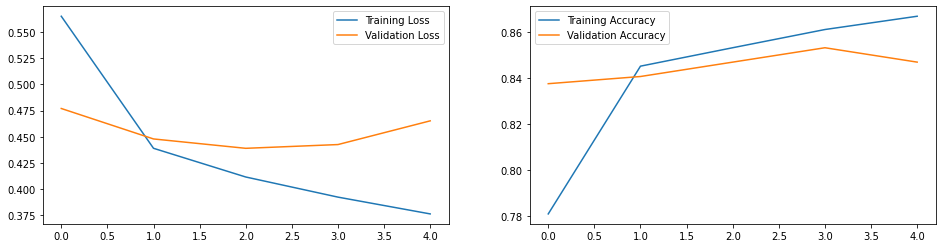

In [249]:
plot_history(history)

### Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [250]:
pred2= RNN_model2.predict(int_test_ds)
# pred2=np.argmax(pred2, axis=1)
print('shape of preds: ', pred2.shape)

238/238 [==============================] - 1s 5ms/step
shape of preds:  (7600, 4)


In [251]:
pred2.shape

(7600, 4)

In [252]:
# print_validation_report(int_val_ds, pred2)

In [253]:
# plot_confusion_matrix(int_val_ds,pred2)

## RNN_Model3  

Bidirectional, Regularization, Default output sequnece layer

### Making the Model

In [254]:
# Define the model

RNN_model3 = tf.keras.Sequential([
                           #  text_vectorization
                              tf.keras.layers.Embedding(input_dim=len(text_vectorization.get_vocabulary())
                              ,output_dim=32
                              ,mask_zero=True)
                              ,tf.keras.layers.Bidirectional(tf.keras.layers.SimpleRNN(32)) # Bidirectional
                              ,tf.keras.layers.Dense(32, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(0.001)) # 4 classes: World, Sports, Business, Sci.Tech
                               # With Regularization
])

In [255]:
# compile the model

RNN_model3.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

In [256]:
# Fit the model

start_time = dt.now()
history = RNN_model3.fit(int_train_ds
                    ,epochs=200
                    ,validation_data=int_val_ds
                    ,validation_steps=10
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)]
                    )
end_time = dt.now()
print(f'RNN_model2 fit time: {end_time-start_time}')

Epoch 1/200
3563/3563 [==============================] - 91s 25ms/step - loss: 0.5016 - accuracy: 0.8176 - val_loss: 0.4241 - val_accuracy: 0.8438
Epoch 2/200
3563/3563 [==============================] - 88s 25ms/step - loss: 0.4099 - accuracy: 0.8539 - val_loss: 0.4069 - val_accuracy: 0.8562
Epoch 3/200
3563/3563 [==============================] - 88s 25ms/step - loss: 0.3816 - accuracy: 0.8639 - val_loss: 0.3922 - val_accuracy: 0.8656
Epoch 4/200
3563/3563 [==============================] - 88s 25ms/step - loss: 0.3592 - accuracy: 0.8725 - val_loss: 0.3965 - val_accuracy: 0.8594
RNN_model2 fit time: 0:06:49.589148


In [257]:
RNN_model3.evaluate(int_test_ds)

238/238 [==============================] - 2s 7ms/step - loss: 0.4344 - accuracy: 0.8479


[0.43443378806114197, 0.8478947281837463]

In [258]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [259]:
print(history.history['val_loss'])
print(history.history['val_accuracy'])

[0.42408737540245056, 0.40693920850753784, 0.3922122120857239, 0.39650586247444153]
[0.84375, 0.856249988079071, 0.8656250238418579, 0.859375]


In [260]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.502,0.818,0.424,0.844
1,0.410,0.854,0.407,0.856
2,0.382,0.864,0.392,0.866
3,0.359,0.873,0.397,0.859


### Plot Training Metrics (Loss and Accuracy)

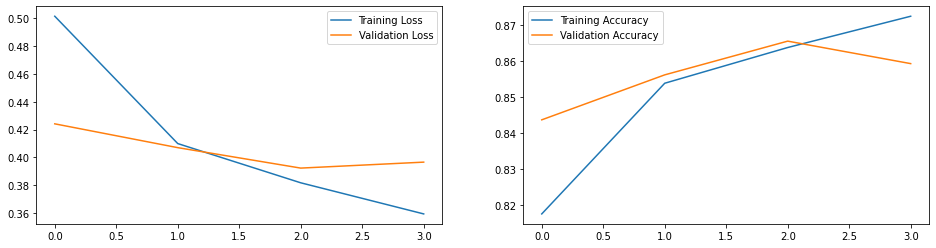

In [261]:
plot_history(history)

### Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [262]:
pred3= RNN_model3.predict(int_test_ds)
pred3=np.argmax(pred3, axis=1)

238/238 [==============================] - 2s 7ms/step


In [263]:
# print_validation_report(int_val_ds, pred3)

In [264]:
# plot_confusion_matrix(int_val_ds,pred3)

## RNN_Model4  

Unidirectional, Regularization, default output sequnece layer 

### Making the Model

In [265]:
# Define the model

RNN_model4 = tf.keras.Sequential([
                           #  text_vectorization
                              tf.keras.layers.Embedding(input_dim=len(text_vectorization.get_vocabulary())
                              ,output_dim=32
                              ,mask_zero=True)
                              ,tf.keras.layers.SimpleRNN(32) # Uniidirectional
                              ,tf.keras.layers.Dense(32, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(0.001)) # With Regularization
])

In [266]:
# compile the model

RNN_model4.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

In [267]:
# Fit the model

start_time = dt.now()
history = RNN_model4.fit(int_train_ds
                    ,epochs=200
                    ,validation_data=int_val_ds
                    ,validation_steps=10
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)]
                    )
end_time = dt.now()
print(f'RNN_model4 fit time: {end_time-start_time}')

Epoch 1/200
3563/3563 [==============================] - 58s 16ms/step - loss: 0.5638 - accuracy: 0.7864 - val_loss: 0.4810 - val_accuracy: 0.8406
Epoch 2/200
3563/3563 [==============================] - 55s 15ms/step - loss: 0.4467 - accuracy: 0.8446 - val_loss: 0.4502 - val_accuracy: 0.8375
RNN_model4 fit time: 0:02:18.325973


In [288]:
RNN_model4.evaluate(int_test_ds)

238/238 [==============================] - 1s 5ms/step - loss: 0.4558 - accuracy: 0.8411


[0.4558011591434479, 0.8410526514053345]

In [268]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [269]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.564,0.786,0.481,0.841
1,0.447,0.845,0.450,0.837


### Plot Training Metrics (Loss and Accuracy)

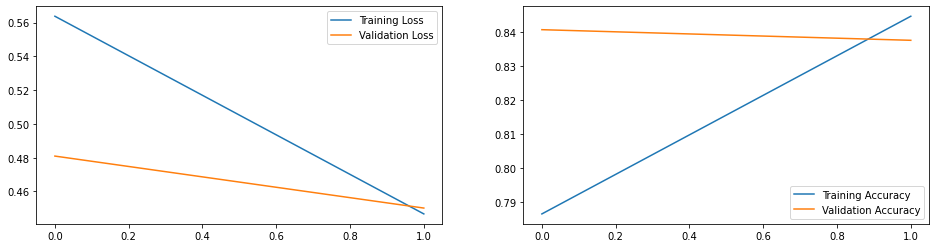

In [270]:
plot_history(history)

### Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [271]:
pred4= RNN_model4.predict(int_test_ds)
pred4=np.argmax(pred4, axis=1)

238/238 [==============================] - 1s 5ms/step


In [272]:
# print_validation_report(int_val_ds, pred4)

In [273]:
# plot_confusion_matrix(val_ds,pred4)

## RNN_Model5  

Bidirectional, Regularization And fixed output sequnece layer 

<div class="alert alert-block alert-success">
    <b>tf.keras.layers.TextVectorization</b><br>
    https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization
    </div>

In [25]:
text_only_train_ds = train_ds.map(lambda x, y: x)

In [36]:
# Text Vectorizer

max_length = 150
max_tokens = 1000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length, # fixed output sequence length
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [275]:
# for text in text_only_train_ds:
#     print(f"Get first batch of {text.shape[0]} news articles.\n")
#     print(f"Here is the first news article:\n\n{text[0]}.")
#     break

Get first batch of 32 news articles.

Here is the first news article:

b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'.


In [276]:
# %%time
# encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
#     max_tokens=1000,
#     output_sequence_length=150, # using output sequence length
#     standardize=custom_stopwords)
# encoder.adapt(train_ds.map(lambda text, label: text))

Cause: could not parse the source code of <function <lambda> at 0x7fb3da0d6f80>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: could not parse the source code of <function <lambda> at 0x7fb3da0d6f80>: no matching AST found among candidates:

To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
CPU times: user 7.22 s, sys: 612 ms, total: 7.83 s
Wall time: 6.22 s


### Making the Model

In [37]:
# Define the model

RNN_model5 = tf.keras.Sequential([
                           #  text_vectorization
                              tf.keras.layers.Embedding(input_dim=len(text_vectorization.get_vocabulary())
                              ,output_dim=32
                              ,mask_zero=True)
                              ,tf.keras.layers.SimpleRNN(32) # Uniidirectional
                              ,tf.keras.layers.Dense(32, activation='relu')
                              ,tf.keras.layers.Dense(4,activation='softmax', kernel_regularizer=tf.keras.regularizers.L2(0.001)) # With Regularization
])

In [38]:
# compile the model

RNN_model5.compile(optimizer='adam'
              ,loss=tf.keras.losses.SparseCategoricalCrossentropy()
              ,metrics=['accuracy'])

In [39]:
# Fit the model

start_time = dt.now()
history = RNN_model5.fit(int_train_ds
                    ,epochs=200
                    ,validation_data=int_val_ds
                    ,validation_steps=10
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=1)]
                    )
end_time = dt.now()
print(f'RNN_model5 fit time: {end_time-start_time}')

Epoch 1/200
3563/3563 [==============================] - 213s 59ms/step - loss: 0.5452 - accuracy: 0.8006 - val_loss: 0.4670 - val_accuracy: 0.8406
Epoch 2/200
3563/3563 [==============================] - 208s 58ms/step - loss: 0.4421 - accuracy: 0.8454 - val_loss: 0.4374 - val_accuracy: 0.8438
Epoch 3/200
3563/3563 [==============================] - 209s 59ms/step - loss: 0.4165 - accuracy: 0.8538 - val_loss: 0.4362 - val_accuracy: 0.8438
RNN_model5 fit time: 0:12:14.212008


In [40]:
RNN_model5.evaluate(int_test_ds)

238/238 [==============================] - 4s 15ms/step - loss: 0.4538 - accuracy: 0.8436


[0.4537889063358307, 0.8435526490211487]

In [41]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [42]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
0,0.545,0.801,0.467,0.841
1,0.442,0.845,0.437,0.844
2,0.417,0.854,0.436,0.844


### Plot Training Metrics (Loss and Accuracy)

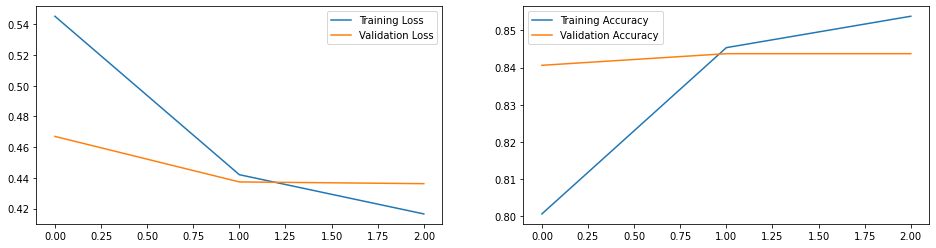

In [43]:
plot_history(history)

### Confusion matrices
Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

In [44]:
pred4= RNN_model5.predict(int_test_ds)
pred4=np.argmax(pred4, axis=1)

238/238 [==============================] - 3s 13ms/step


In [45]:
# print_validation_report(int_val_ds, pred4)

In [46]:
# plot_confusion_matrix(val_ds,pred4)